In [6]:
!pip install graphviz


  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   ----------------- ---------------------- 20.5/47.1 kB 682.7 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 594.9 kB/s eta 0:00:00


# Ordinary Least Square

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from scipy.stats import boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as smgt
from statsmodels.stats import stattools
from sklearn.preprocessing import StandardScaler,Normalizer,LabelEncoder,PolynomialFeatures,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV,StratifiedKFold,learning_curve,KFold,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,SGDRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel, RFE,SelectPercentile,f_regression,VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [58]:
df = pd.read_csv('palm_ffb.csv')
df.head()

,Date,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
0,01.01.2008,616.4,25.306452,21.3,32.2,184.4,25,777778.3951,1.62
1,01.02.2008,568.9,26.165517,20.9,35.1,140.2,23,767988.2759,1.45
2,01.03.2008,577.6,25.448387,21.3,32.9,280.4,25,783951.9231,1.56
3,01.04.2008,581.1,26.903333,20.6,34.8,173.3,25,788987.0504,1.39
4,01.05.2008,545.4,27.241935,20.9,35.0,140.6,25,813659.7222,1.44


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           130 non-null    object 
 1   SoilMoisture   130 non-null    float64
 2   Average_Temp   130 non-null    float64
 3   Min_Temp       130 non-null    float64
 4   Max_Temp       130 non-null    float64
 5   Precipitation  130 non-null    float64
 6   Working_days   130 non-null    int64  
 7   HA_Harvested   130 non-null    float64
 8   FFB_Yield      130 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.3+ KB


In [12]:
df.drop('Date', axis=1, inplace= True)

KeyError: "['Date'] not found in axis"

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SoilMoisture,130.0,527.646923,57.367844,380.700000,488.625000,538.300000,571.025000,647.3000
Average_Temp,130.0,26.849918,0.651413,25.158065,26.442285,26.930645,27.270726,28.5800
Min_Temp,130.0,21.379231,0.688971,18.900000,21.000000,21.500000,21.800000,22.6000
Max_Temp,130.0,33.851538,1.079638,31.100000,33.100000,33.900000,34.600000,36.0000
Precipitation,130.0,188.980769,80.237210,2.000000,140.300000,182.150000,226.100000,496.1000
Working_days,130.0,24.753846,1.239289,21.000000,24.000000,25.000000,26.000000,27.0000
HA_Harvested,130.0,793404.491565,34440.893854,683431.944400,768966.949100,790036.158050,821989.235250,882254.2254
FFB_Yield,130.0,1.602231,0.281751,1.080000,1.390000,1.585000,1.807500,2.2700


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SoilMoisture   130 non-null    float64
 1   Average_Temp   130 non-null    float64
 2   Min_Temp       130 non-null    float64
 3   Max_Temp       130 non-null    float64
 4   Precipitation  130 non-null    float64
 5   Working_days   130 non-null    int64  
 6   HA_Harvested   130 non-null    float64
 7   FFB_Yield      130 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 8.3 KB


<Axes: xlabel='FFB_Yield', ylabel='Density'>

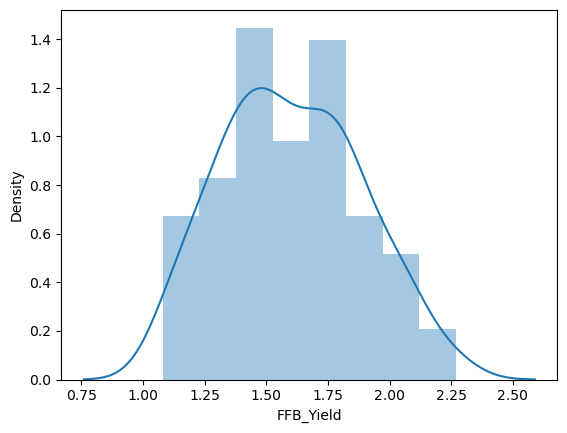

In [15]:
sns.distplot(df['FFB_Yield'])

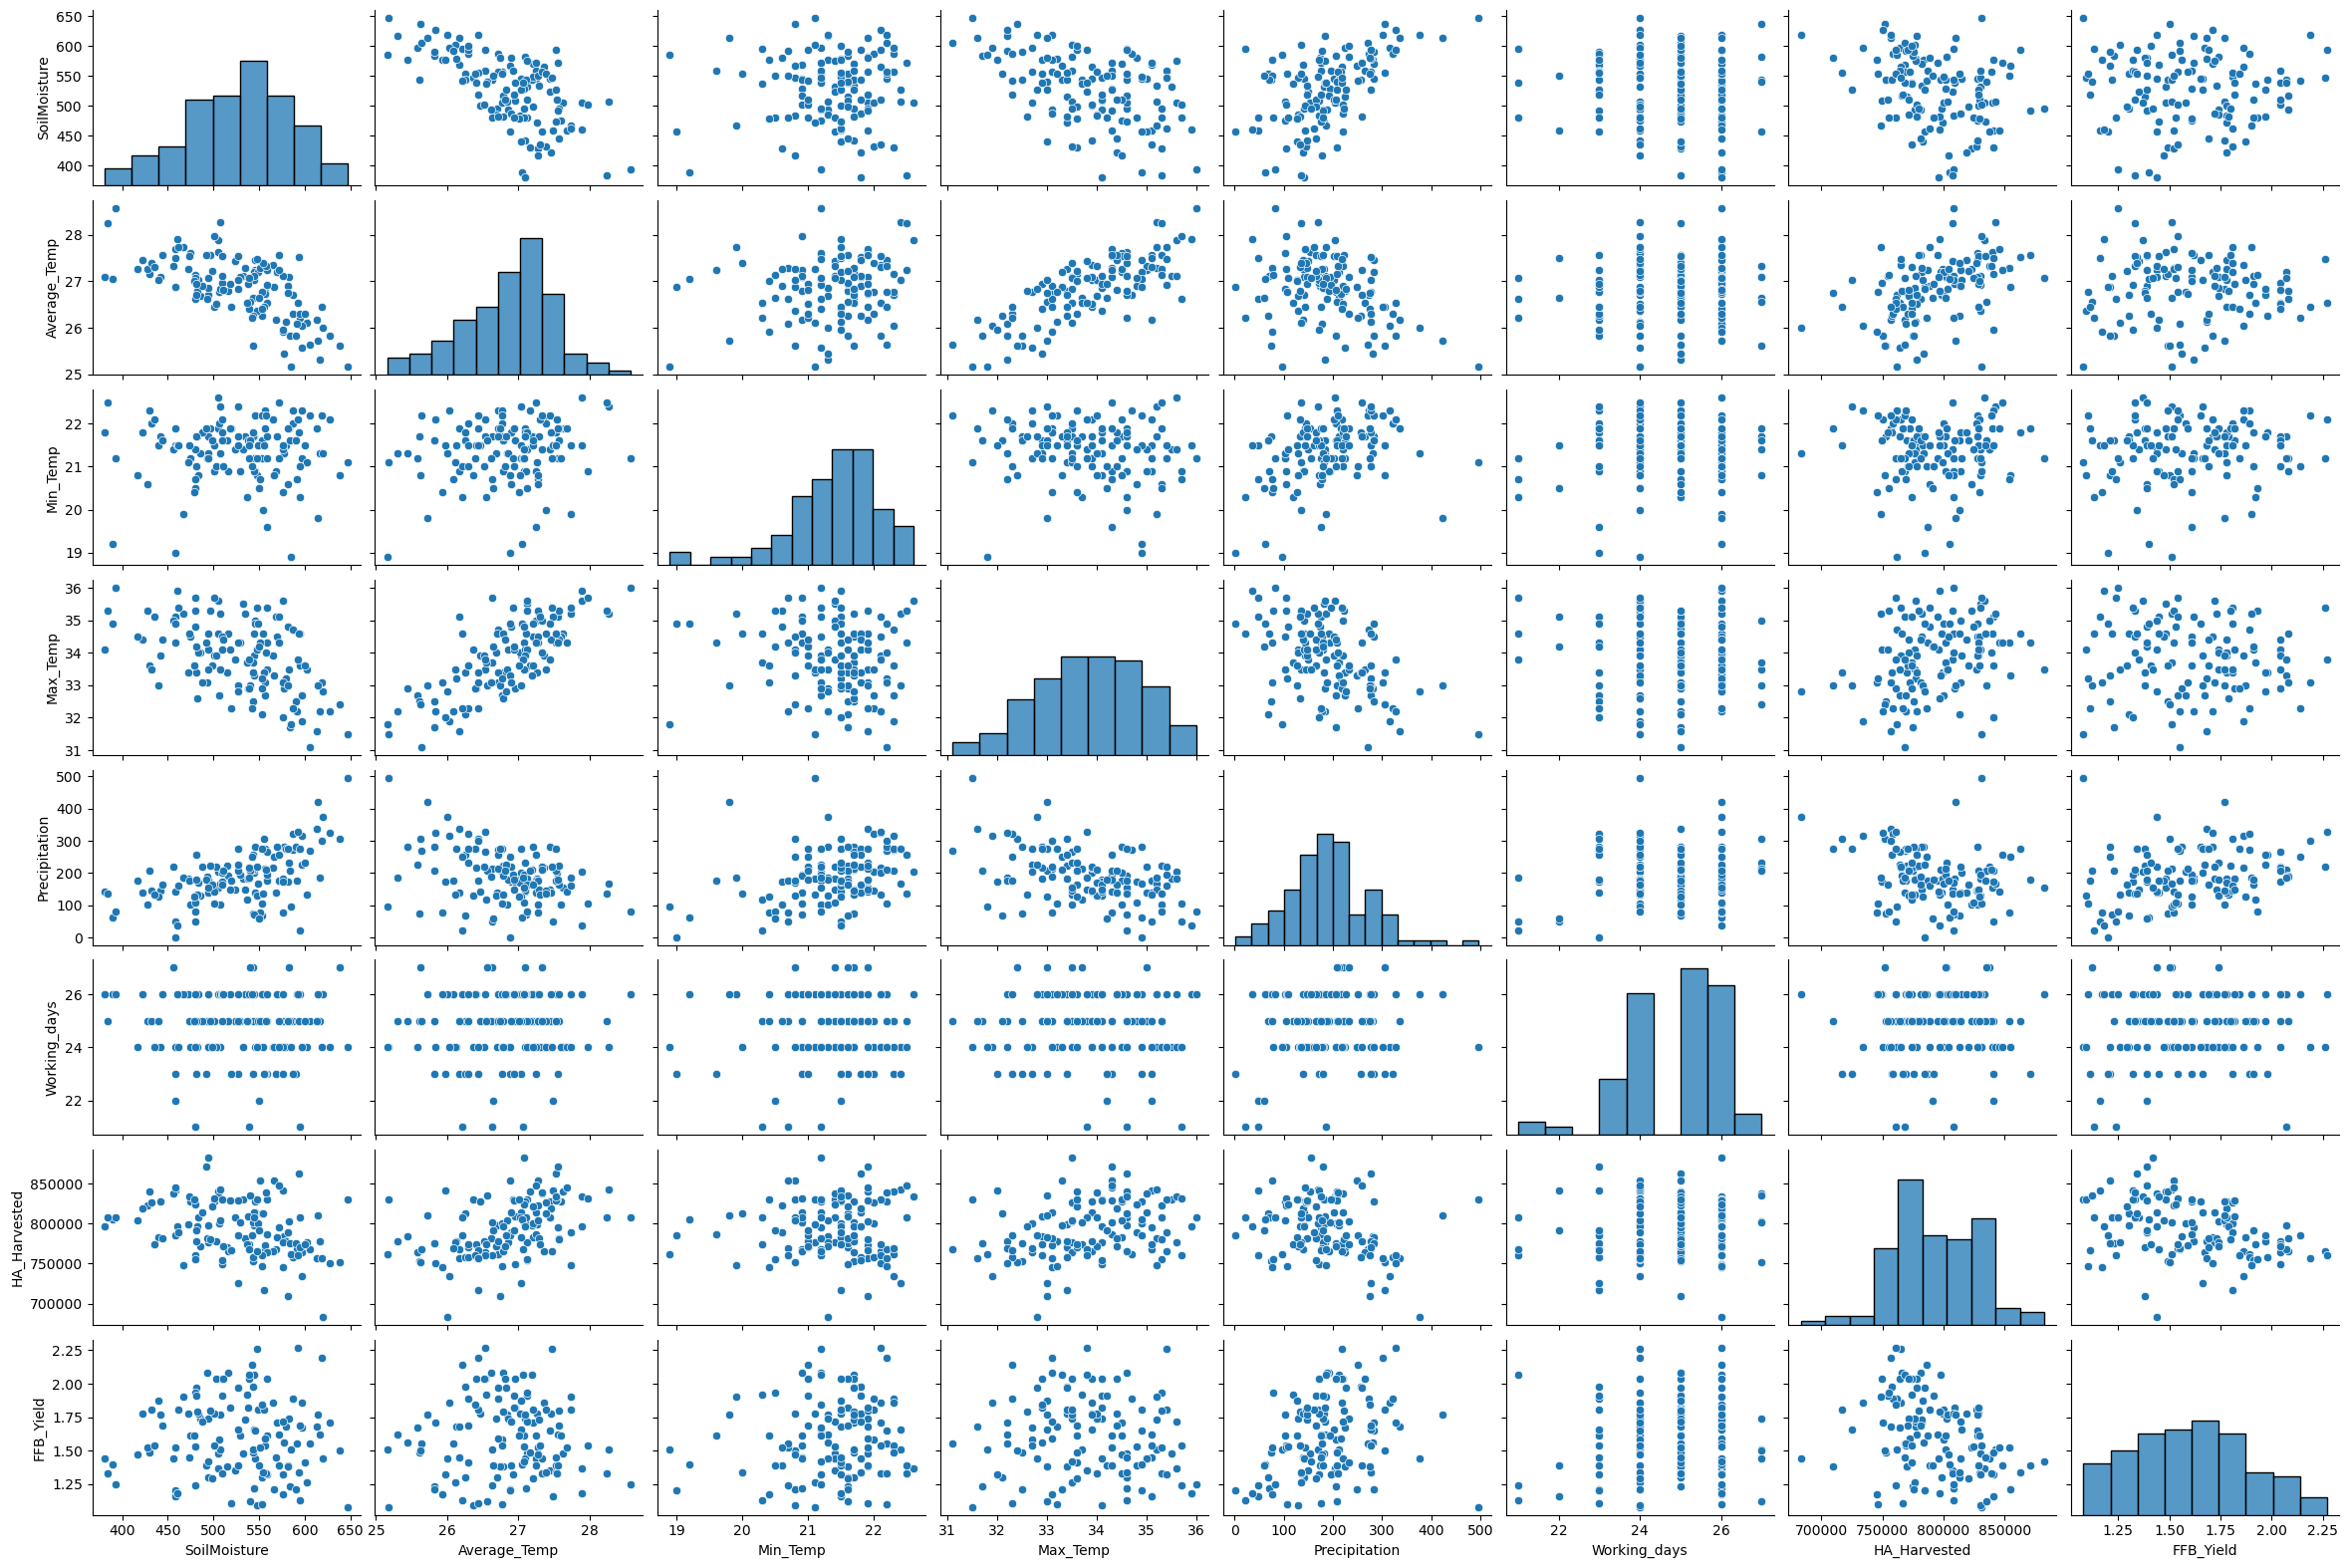

In [16]:
sns.pairplot(df, height = 2, aspect = 1.5)

In [17]:
numeric_features = list(df.columns[df.dtypes != 'object'].values)
print("Numeric features :" ,numeric_features)
numeric_features.remove('FFB_Yield')

Numeric features : ['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Max_Temp', 'Precipitation', 'Working_days', 'HA_Harvested', 'FFB_Yield']


In [19]:
#MultiCollinearity Test VIF Analysis Variance Inflation Analysis : Run regression and find collinearity of features 1 : not correlated. (1-5) : moderately correlated. (>5) : highly correlated.
def calculate_vif(X):
    X['intercept'] = 1
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    vif['VIF Factor'] = round(vif['VIF Factor'],2)
    vif = vif[vif['features'] != 'intercept']
    vif.sort_values('VIF Factor',ascending=False,inplace=True)
    return vif
calculate_vif(df[numeric_features])

,VIF Factor,features
1,4.32,Average_Temp
3,3.03,Max_Temp
0,2.21,SoilMoisture
4,1.89,Precipitation
2,1.46,Min_Temp
6,1.28,HA_Harvested
5,1.06,Working_days


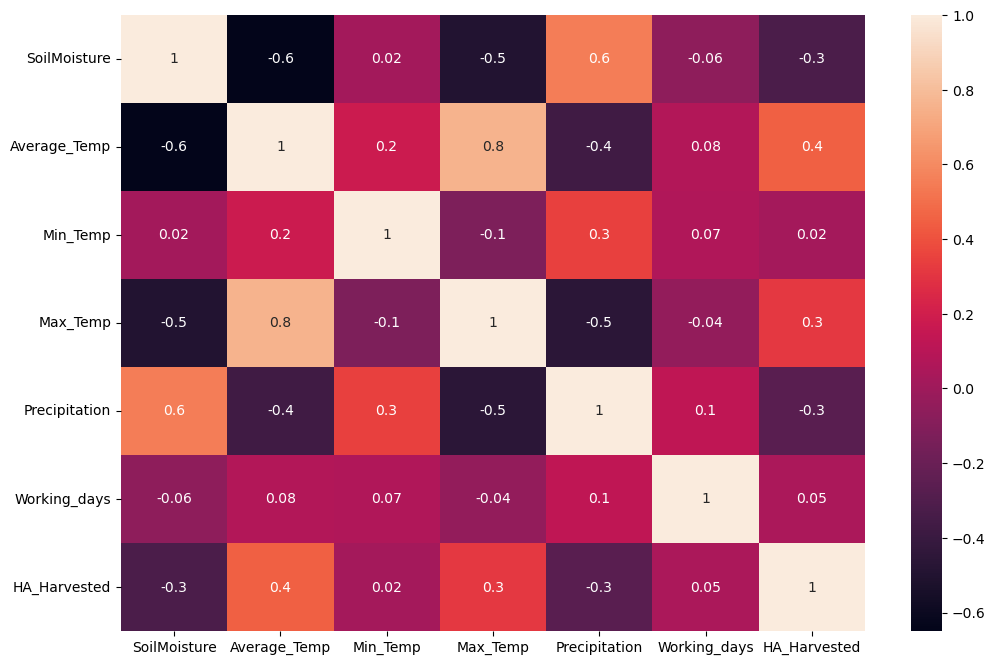

In [20]:
corr_matrix_1 = np.corrcoef(df[numeric_features],rowvar=False)
corr_matrix_1 = df[numeric_features].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix_1,annot=True,fmt='.1g')
plt.show()

Linear Regression Assumptions

Bias vs Variance trade off Handling of outlier data points Linearity between response & predictor features No perfect multicollinearity between the predictors (via VIF Factor or correlation) Zero mean of the residuals and Homoscedasticity (constant variance) Normality of residuals No autocorrelation of residuals Performance Measures

R2 increases whenever a new feature is added to the model. R2_adj increases whenever an improving feature is added to the model. High R2 doesn't mean good fit Exceptions Use Lars Regression for high dimensional data

In [21]:
def scale_data(X):
    return pd.DataFrame(StandardScaler().fit_transform(X),columns = X.columns.values)

In [22]:
def make_data(n_points, err = 1.0, random_state = 42):
    rnd_gen = np.random.RandomState(random_state)
    X = rnd_gen.rand(n_points, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rnd_gen.randn(n_points)
    return X, np.abs(y)

In [23]:
def set_poly_feature(X,y,degree,plot_type = 'reg'):
    poly = PolynomialFeatures(degree = degree)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    lr.fit(X_poly,y)
    y_pred = lr.predict(X_poly)
    if plot_type == 'reg':
        sns.regplot(x='X',y='y',data = dftemp,fit_reg=False)
        sns.lineplot(dftemp['X'],y_pred,c = 'r',lw = 1,label = 'degree ' + str(degree))
        plt.legend(loc='upper left')
    else:
        residuals = y_pred - y
        sns.scatterplot(x = y_pred,y = residuals)
        plt.axhline(y = 0, c = 'r', lw = 1)
        plt.title('Residual for degree ' + str(degree))

In [24]:
def plot_residuals(y_pred,residuals):
    print("Durbin-Watson test statistics is " + str(round(stattools.durbin_watson(residuals),2)))
    fig,ax = plt.subplots(1,3,figsize=(18,4))
    sns.scatterplot(x = y_pred,y = residuals,ax = ax[0])
    ax[0].axhline(y=0, c='r', lw=1)
    stats.probplot(residuals, plot = ax[1])
    smgt.plot_acf(residuals,ax = ax[2])
    plt.show()

In [25]:
def print_reg_result(estimator,X,y,y_pred):
    mse = round(mean_squared_error(y, y_pred),2)
    print("Mean Square Error (MSE): ", mse)

    rmse = round(np.sqrt(mse),2)
    print("Root Mean Square Error (RMSE):", rmse)

    mae = round(mean_absolute_error(y,y_pred),2)
    print("Mean Absolute Error :", mae)

    r_sq = round(estimator.score(X, y),2)
    print('R-square         :', r_sq)
    
    adj_r_sq = round(1 - (1 - r_sq) * (len(y) - 1) / (len(y_pred) - X.shape[1] - 1),2)
    print('R-square adj.    :',adj_r_sq)

In [27]:
X = df[numeric_features]
y = df['FFB_Yield']

2.73 [-0.    0.09 -0.02 -0.01  0.    0.01 -0.  ]
Mean Square Error (MSE):  0.06
Root Mean Square Error (RMSE): 0.24
Mean Absolute Error : 0.19
R-square         : 0.25
R-square adj.    : 0.21
Durbin-Watson test statistics is 0.59


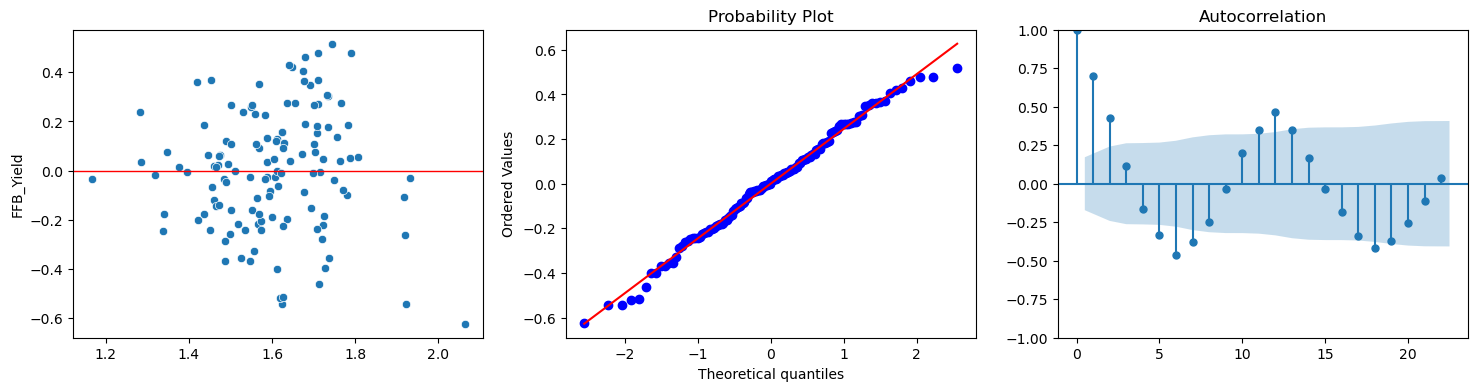

In [28]:
lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
residuals = y - y_pred
print(round(lr.intercept_,2),np.round(lr.coef_,2))
print_reg_result(lr,X,y,y_pred)
plot_residuals(y_pred,residuals)

In [29]:
df[numeric_features]

,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested
0,616.4,25.306452,21.3,32.2,184.4,25,777778.3951
1,568.9,26.165517,20.9,35.1,140.2,23,767988.2759
2,577.6,25.448387,21.3,32.9,280.4,25,783951.9231
3,581.1,26.903333,20.6,34.8,173.3,25,788987.0504
4,545.4,27.241935,20.9,35.0,140.6,25,813659.7222
...,...,...,...,...,...,...,...
125,498.2,27.213333,21.6,33.6,165.6,24,820758.9147
126,494.7,27.074194,21.2,33.5,154.7,26,882254.2254
127,478.8,27.016129,20.4,33.6,127.2,25,829488.8199
128,481.1,26.946667,21.0,34.2,180.6,23,792101.0471


In [30]:
model = smf.ols('FFB_Yield ~ SoilMoisture + Average_Temp + Min_Temp + Max_Temp + Precipitation + Working_days + HA_Harvested ', data = df)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:              FFB_Yield   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     5.935
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           5.92e-06
Time:                        23:50:28   Log-Likelihood:               -0.23443
No. Observations:                 130   AIC:                             16.47
Df Residuals:                     122   BIC:                             39.41
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.7331      1.520      1.798

Reference
1.https://medium.com/@VitorCSampaio/understanding-ordinary-least-squares-ols-the-foundation-of-linear-regression-1d79bfc3ca35#:~:text=The%20OLS%20model%20is%20a,%3A%20%22dependent_variable%20~%20independent_variables%22%20.
2.https://medium.com/@mygreatlearning/step-by-step-regression-analysis-f7e3e3ebf296
3.https://medium.com/analysts-corner/the-complete-guide-to-regression-analysis-understanding-implementing-and-optimizing-regression-993ead8b2d5e


# Time Series Plot


In [59]:
# reorder and select columns related
df_ts = df[['Date','FFB_Yield']]

# Show top results
df_ts.head(5)

,Date,FFB_Yield
0,01.01.2008,1.62
1,01.02.2008,1.45
2,01.03.2008,1.56
3,01.04.2008,1.39
4,01.05.2008,1.44


In [60]:
df_ts['Date'] = pd.to_datetime(df_ts['Date'], format='%d.%m.%Y')

In [61]:
df_ts['Date'] = df_ts['Date'].dt.strftime('%Y-%m')
df_ts = df_ts.sort_values(by='Date', ascending=True)
df_ts.set_index('Date', inplace=True)
df_ts.head(30)


,FFB_Yield
Date,
2008-01,1.62
2008-02,1.45
2008-03,1.56
2008-04,1.39
2008-05,1.44
2008-06,1.48
2008-07,1.66
2008-08,1.71
2008-09,1.62


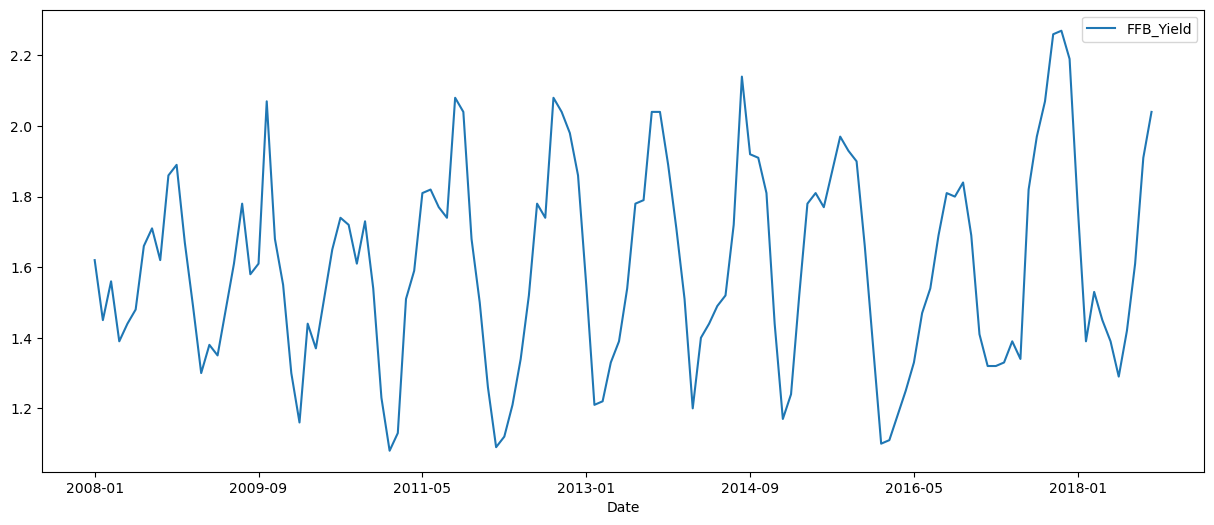

In [63]:
df_ts.plot(figsize=(15, 6))
plt.show()

Reference 
1. https://towardsdatascience.com/time-series-forecasting-based-on-the-trend-and-seasonal-components-26b92866e548
2. https://medium.com/analytics-vidhya/time-series-forecasting-a-complete-guide-d963142da33f
3. https://medium.com/@wainaina.pierre/the-complete-guide-to-time-series-forecasting-models-ef9c8cd40037